In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from plotly import __version__
from plotly import tools
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

import cufflinks as cf

# For Notebooks
init_notebook_mode(connected=True)

# For offline use
cf.go_offline()


from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

from datetime import datetime
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
import re
import os
import time

4.10.0


 # Data Inspection

In [2]:
pd.set_option('display.max_colwidth', 1)

In [3]:
df_train = pd.read_csv('../datasets/drugsComTrain_raw.tsv', sep='\t')

In [4]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",9.0,"November 27, 2016",37


In [5]:
df_test = pd.read_csv('../datasets/drugsComTest_raw.tsv', sep='\t')

In [6]:
df_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me.""",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done very well on the Asacol. He has no complaints and shows no side effects. He has taken as many as nine tablets per day at one time. I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically.""",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesity is caused from sugar/carb addiction, which is just as powerful as any drug. I have been taking it for five days, and the good news is, it seems to go to work immediately. I feel hungry before I want food now. I really don&#039;t care to eat; it&#039;s just to fill my stomach. Since I have only been on it a few days, I don&#039;t know if I&#039;ve lost weight (I don&#039;t have a scale), but my clothes do feel a little looser, so maybe a pound or two. I&#039;m hoping that after a few months on this medication, I will develop healthier habits that I can continue without the aid of Contrave.""",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend""",9.0,"October 22, 2015",4


In [7]:
# Creating a text length column
df_train['text length'] = df_train['review'].apply(len)
df_test['text length'] = df_test['review'].apply(len)

# Creating a sentiment column
df_train['sentiment_rate'] = df_train['rating'].apply(lambda s: 1 if (s>=6) else 0)
df_test['sentiment_rate'] = df_test['rating'].apply(lambda s: 1 if (s>=6) else 0)

In [8]:
df_train.rename(columns={'Unnamed: 0': 'uniqueid'}, inplace=True)
df_test.rename(columns={'Unnamed: 0': 'uniqueid'}, inplace=True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   uniqueid        161297 non-null  int64  
 1   drugName        161297 non-null  object 
 2   condition       160398 non-null  object 
 3   review          161297 non-null  object 
 4   rating          161297 non-null  float64
 5   date            161297 non-null  object 
 6   usefulCount     161297 non-null  int64  
 7   text length     161297 non-null  int64  
 8   sentiment_rate  161297 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 11.1+ MB


### Comment

There are 161297 entries in training set, there seem to have some null values in condition feature. 

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uniqueid        53766 non-null  int64  
 1   drugName        53766 non-null  object 
 2   condition       53471 non-null  object 
 3   review          53766 non-null  object 
 4   rating          53766 non-null  float64
 5   date            53766 non-null  object 
 6   usefulCount     53766 non-null  int64  
 7   text length     53766 non-null  int64  
 8   sentiment_rate  53766 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 3.7+ MB


### Comment
There are 53765 entries in testing set, there seem to have some null values in condition feature. 

In [11]:
df_train.describe()

,uniqueid,rating,usefulCount,text length,sentiment_rate
count,161297.000000,161297.000000,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755,458.726238,0.701867
std,67004.445170,3.272329,36.403742,242.130235,0.457440
min,2.000000,1.000000,0.000000,3.000000,0.000000
25%,58063.000000,5.000000,6.000000,262.000000,0.000000
50%,115744.000000,8.000000,16.000000,455.000000,1.000000
75%,173776.000000,10.000000,36.000000,691.000000,1.000000
max,232291.000000,10.000000,1291.000000,10787.000000,1.000000


### Comment
The mean rating is 6.77 which is rather high (highest rating is 10, lowest rating is 1). Standard deviation of rating is 3.27 meaning the data points are close together, not widely spread out. As for useful count, the mean is 28 and standard deviation is 36.4. It has a high standard deviation, meaning the data points are widely spread out. The minimum useful count is 0, maximum is 1291.

In [12]:
df_test.describe()

,uniqueid,rating,usefulCount,text length,sentiment_rate
count,53766.000000,53766.000000,53766.000000,53766.000000,53766.000000
mean,116386.701187,6.976900,27.989752,458.304282,0.698564
std,67017.739881,3.285207,36.172833,237.559635,0.458886
min,0.000000,1.000000,0.000000,3.000000,0.000000
25%,58272.500000,4.000000,6.000000,262.000000,0.000000
50%,116248.500000,8.000000,16.000000,457.000000,1.000000
75%,174586.750000,10.000000,36.000000,689.000000,1.000000
max,232284.000000,10.000000,949.000000,6192.000000,1.000000


In [13]:
df_train.isnull().sum()

uniqueid          0  
drugName          0  
condition         899
review            0  
rating            0  
date              0  
usefulCount       0  
text length       0  
sentiment_rate    0  
dtype: int64

In [14]:
# Less than 1% of data is null, I will drop na
(df_train['condition'].isnull().sum())/len(df_train)

0.005573569254232875

In [15]:
df_test.isnull().sum()

uniqueid          0  
drugName          0  
condition         295
review            0  
rating            0  
date              0  
usefulCount       0  
text length       0  
sentiment_rate    0  
dtype: int64

In [16]:
# Less than 1% of data is null, I will drop na
(df_test['condition'].isnull().sum())/len(df_test)

0.0054867388312316336

### Comment
There are some null values in condition. Needs to be cleaned later. 

In [17]:
len(df_train['condition'].value_counts().unique())

218

In [18]:
len(df_train['drugName'].value_counts().unique())

322

### Comment
There are 218 unique conditions and 322 unique drug name. 

In [19]:
df_train['drugName'].value_counts().head(10)

Levonorgestrel                        3657
Etonogestrel                          3336
Ethinyl estradiol / norethindrone     2850
Nexplanon                             2156
Ethinyl estradiol / norgestimate      2117
Ethinyl estradiol / levonorgestrel    1888
Phentermine                           1543
Sertraline                            1360
Escitalopram                          1292
Mirena                                1242
Name: drugName, dtype: int64

### Comment
- The top three drugs are Levonrgestrel, Etonogestrel and Ethinyl Estradiol / Norethindrone

In [20]:
df_train['condition'].value_counts().head(10)

Birth Control      28788
Depression         9069 
Pain               6145 
Anxiety            5904 
Acne               5588 
Bipolar Disorde    4224 
Insomnia           3673 
Weight Loss        3609 
Obesity            3568 
ADHD               3383 
Name: condition, dtype: int64

### Comment
- The top 3 conditions are Birth Control, Depression and Pain. 

In [21]:
df_train['usefulCount'].sort_values(ascending=False).head(10)

33552     1291
6716      1291
4249      1247
21708     1247
146145    949 
58608     796 
16889     796 
152838    771 
2039      771 
5218      730 
Name: usefulCount, dtype: int64

### Comment
The most useful review has 1291 useful count. 

In [22]:
# Top 10 comments
df_train.iloc[[6716,33552,4249,21708,146145,58608,16889,152838,2039,5218]]

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill.""",10.0,"July 31, 2008",1291,964,1
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill.""",10.0,"July 31, 2008",1291,964,1
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I think it&#039;s the best thing ever. When I first got it put in I only bled for about a week with a little cramping. After that nothing at all. I haven&#039;t had a period for about 8months until I finally got one, and its not bad at all. It&#039;s light, no cramping, no headache, nothing. I haven&#039;t gained weight, my acne is gone, and my moods are fine. I know all women are different, but I just hear all these horror stories and I just wanted to tell my story, which is a good one. Hope it calms some of your fears.""",10.0,"April 1, 2009",1247,570,1
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I think it&#039;s the best thing ever. When I first got it put in I only bled for about a week with a little cramping. After that nothing at all. I haven&#039;t had a period for about 8months until I finally got one, and its not bad at all. It&#039;s light, no cramping, no headache, nothing. I haven&#039;t gained weight, my acne is gone, and my moods are fine. I know all women are different, but I just hear all these horror stories and I just wanted to tell my story, which is a good one. Hope it calms some of your fears.""",10.0,"April 1, 2009",1247,570,1
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two years. I am a more relaxed and easy-going person because of Zoloft. Prior to starting the medicine, I was anxious all the time, worried constantly about everything, and suffered periods of depression and hopelessness. Now I am a better wife, friend, and person in general.""",9.0,"August 5, 2008",949,319,1
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past 9 years. I have to say it&#039;s the BEST pill for losing weight and the ONLY thing tha

### Comment

- Most of the top reviews come from conditions such as Depression, Weight Loss and Birth Control. 
- The top reveiws are mostly positive comments, it talks about the effectiveness of the drug, maybe some side effects and some motivation. 

In [23]:
df_train['usefulCount'].sort_values(ascending=False).tail(10)

50714     0
156716    0
50788     0
107240    0
156719    0
156720    0
134835    0
50779     0
156724    0
51326     0
Name: usefulCount, dtype: int64

In [24]:
# Bottom 10 comments
df_train.iloc[[50714, 156716, 50788, 107240, 156719, 156720, 134835, 50779, 156724, 51326]]

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate
50714,668,Medroxyprogesterone,NaN,"""This the only birth control that gets rid of my cramps and makes that time of the month much more pleasant. I&#039;ve been on it for almost a year. The only thing I do experience is being dry every once in a while but that&#039;s an easy fix. I don&#039;t bleed so much and I never have to think twice about a condom. """,9.0,"October 2, 2011",0,320,1
156716,47701,Adapalene,Acne,"""I owe my self-confidence to adapalene! I went off to college in the fall and my skin immediately went completely out of wack. My doctor started out by prescribing me spironolactone to clear my skin, but I did not like the side effects. Her next suggestion was adapalene, and I couldn&#039;t be happier about deciding to start using it. I simultaneously started applying adapalene when I started hormonal birth control, so some of my clear skin could be because of the bc. I experienced about 3 weeks of an initial breakout, but by the 4th and 5th weeks I got to witness my skin get clearer and clearer everyday. It has now been 8 weeks, and all my breakouts are almost completely gone! My skin is dry, but loading it up with moisturizer every night is absolutely worth it.""",10.0,"December 9, 2017",0,774,1
50788,187455,Monistat 3-Day Combination Pack,Vaginal Yeast Infection,"""I have never gotten a YI, but I decided to get the 3 day tx. Today is my third day and the itchiness and burning is still there! It might be worse than the first 2 times. It&#039;s such a horrible, intense burning sensation that starts a couple minutes after insertion. It had me squirming like a worm with my legs clenched together. Not sure if that means it&#039;s working but I sure hope it&#039;s worth the pain.""",6.0,"January 27, 2016",0,418,1
107240,90057,Ambrisentan,Pulmonary Hypertension,"""caused kidney failure and needed dialysis""",1.0,"April 11, 2016",0,43,0
156719,1139,Sumatriptan,Migraine,"""Fabulous medication after getting to the point I was taking 16 200mg ibuprofen (way too many) a day and at least 8 paracetamol and not even getting relief this came as a god send. Worked wonderfully.""",10.0,"June 5, 2017",0,201,1
156720,221133,Drysol,0</span> users found this comment helpful.,"""I was prescribed drysol because I found a lump in my armpit and my doctor thought it could be a clogged pore. The lump was gone within a week and so was any sweat! It wasn&#039;t painful for me, sometimes a little bit of itchiness but that&#039;s it. I just want to say to anyone who is experiencing pain, make sure you do not apply to freshly shaved armpits! The pharmisist told me this, one time I had shaved but forgot to put the drysol on before so I had to put it on after. I was in a lot of pain and it was very itchy. Otherwise this is a great product! I do sweat a lot on my hands and feet but when I use drysol it will stop for weeks!""",10.0,"October 16, 2016",0,645,1
134835,637,Medroxyprogesterone,Birth Control,"""I have been using this since the birth of my second child 14 and 1/2 years ago. I love it. No periods. No daily medicines to try to remember. I have had a bone density scan and it was normal so worries there either. I think it is great!""",9.0,"July 29, 2009",0,238,1
50779,1174,Sumatriptan,Migraine,"""I&#039;d taken Excedrin for years w/some effectiveness &amp; then had a streak where headaches would return within a day and sought medical attention. An urgent care doctor prescribed Bubalbital-APAP-Caffeine and I used it as needed for about a year and was happy with the results, but the prescription was running out. Because the medication was prescribed by an urgent care doctor the prescription couldn&#039;t be refilled, so I had to see an internal medicine doctor and he prescribed Sumatriptan. After taking the medicine today it did eventually take away my visual auras and it seems to block the full on migraine, but I feel kind of crummy with sinus drainage and pr

### Comment


In [25]:
# Lets check for duplicates 
df_train[df_train['review'].duplicated(keep=False)].sort_values(by='review', ascending=False)

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate
110436,228830,Tadalafil,Erectile Dysfunction,"""❤️❤️❤️ Cialis for US!! I wish I had my husband start this decades ago """,10.0,"August 7, 2017",12,75,1
86737,155791,Cialis,Erectile Dysfunction,"""❤️❤️❤️ Cialis for US!! I wish I had my husband start this decades ago """,10.0,"August 7, 2017",12,75,1
107645,123799,Skyla,Birth Control,"""you know that feeling when you miss your period by a couple of days when you&#039;re on the pill? The one where you google signs of pregnancy- moody, , bloating,tired (what I feel everyday of my life) and then they tell you are pregnant and have all the STD&#039;s. Then your heart drops you freak out and can&#039;t concentrate at work. Yeah that one. \r\n\r\nI haven&#039;t had that feeling in two years because of skyla and it is the bomb.""",10.0,"November 23, 2016",18,440,1
85038,166377,Levonorgestrel,Birth Control,"""you know that feeling when you miss your period by a couple of days when you&#039;re on the pill? The one where you google signs of pregnancy- moody, , bloating,tired (what I feel everyday of my life) and then they tell you are pregnant and have all the STD&#039;s. Then your heart drops you freak out and can&#039;t concentrate at work. Yeah that one. \r\n\r\nI haven&#039;t had that feeling in two years because of skyla and it is the bomb.""",10.0,"November 23, 2016",18,440,1
144899,86962,Latuda,Schizophrenia,"""you can go insane if you get off this drug cold-turkey and if your drinking/drugs inbetween you will end up at the hospital like me, i stopped using for 3 months now, the last few days have been a nightmare I was smoking weed while not taking latuda, and I had a depressive breakdown where i ended up in emergency twice in the past 4 days, i was so fatigued my eyes were shutting on their own and i thought i was going to die if i fall asleep, its a feeling of insanity dont mess around with this drug. Go step by step as your doctor tells you, overall the drug has its ups and downs some of the side effects are dreadfull, goodluck""",4.0,"November 1, 2016",6,634,0
...,...,...,...,...,...,...,...,...,...
9906,148712,Mirena,Birth Control,"""\r\nI got tired of taking the pill so I figured this might be a great alternative. Boy was I wrong.\r\n\r\nYes, it kept me from getting pregnant but it gave me bacterial vaginosis on every other week...and I only had it inserted for a month and a half!\r\n\r\nI would get the BV treated, and it be right back like clock work. Also, my partner reported that the strings were uncomfortable and they poked him during intercourse.\r\n\r\nGlad to report that 9 months after I have had it removed, I have not had a single stint of bacterial vaginosis and I am sticking with the pill.""",3.0,"June 8, 2016",1,565,0
133273,191485,Lisdexamfetamine,ADHD,"""\r\nGood. Concentration, happy, easy to talk to\r\n\r\nBad: ECG showed it was bad for my heart, had to stop. Anxiety, afraid and didn&#039;t know why. Although it made me happy it felt fake and like I was a prisoner in my mind just pleasing others. I won&#039;t take it to please others. \r\n\r\nMeds basically free in my country after reaching over $300 cause third highest tax paying country in the world.""",5.0,"October 17, 2015",10,400,0
145940,37325,Vyvanse,ADHD,"""\r\nGood. Concentration, happy, easy to talk to\r\n\r\nBad: ECG showed it was bad for my heart, had to stop. Anxiety, afraid and didn&#039;t know why. Although it made me happy it felt fake and like I was a prisoner in my mind just pleasing others. I won&#039;t take it to please others. \r\n\r\nMeds basically free in my country after reaching over $300 cause third highest tax paying country in the world.""",5.0,"October 17, 2015",10,400,0
97789,83898,Ethinyl estradiol / norgestimate,Birth Control,"""\r\nFirst of all, the worst side effect for me is the constant yeast infections. Never had one in my life until I started this pill, now I will have one constantly, cu

### Comment
There seems to be some duplicated rows. Needs to be cleaned later. 

In [26]:
# Lets count how many top ratings are there
len(df_train[df_train['rating']==10])
# There are 50989 top rating comments

50989

In [27]:
# Lets check out some of the high rating comments
df_train[df_train['rating']==10].head(10)

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage. My moods were out of control. I was depressed and hopeless one second and then mean, irrational, and full of rage the next. My Dr. prescribed me 2mg of Abilify and from that point on I feel like I have been cured though I know I&#039;m not.. Bi-polar disorder is a constant battle. I know Abilify works for me because I have tried to get off it and lost complete control over my emotions. Went back on it and I was golden again. I am on 5mg 2x daily. I am now 21 and better than I have ever been in the past. Only side effect is I like to eat a lot.""",10.0,"March 14, 2015",32,733,1
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.""",10.0,"March 9, 2017",54,460,1
18,212077,Lamotrigine,Bipolar Disorde,"""I&#039;ve been on every medicine under the sun (it seems) to manage the hypomania / mania of Bipolar2. Within a few days of starting Lamictal (was on Tegretol) it was as if someone had turned a light on in my head. Is this the way &quot;normal&quot; people think? was one of the first things that struck me. I sleep like a log, have no irritability, almost no anger (other than what would be considered normal). I am able to focus and my creative, impulsive thoughts have decreased enough to be manageable. It&#039;s a God send as I would perennially be in a state of hypo mania, which sounds great, but I was physically and emotionally exhausted. My libido is markedly lower but I wonder if that is perhaps an effect of not being hypo manic. I take 20 mg for anxiety.""",10.0,"November 9, 2014",18,770,1
19,119705,Nilotinib,Chronic Myelogenous Leukemia,"""I have been on Tasigna for just over 3 years now (300mg x 2 times a day) Tasigna worked for me within a few weeks I have been in remission for basically the entire 3 years. As for the side effects, I feel sick to my stomach, tired, severe leg and arm pain, I can&#039;t walk to long without needing a break, I went from working full time to not working at all because I am so tired all the time.... but hey I am in remission and alive so is all the above really a problem? Nope""",10.0,"September 1, 2015",11,480,1
21,231466,Trazodone,Insomnia,"""I have insomnia, it&#039;s horrible. My story begins with my PCP prescribing me Prozac to help with intestinal issues, because I was desperate I tried it, I was on it for 3 weeks. Stopped because of insomnia. Then I was prescribed Ativan, it out me out, but was very addicting. I had rebound insomnia. Then after about 14 days I hardly any sleep l tried the doctor one more time. I asked him about Trazadone. He told me that was a good medication for insomnia. He put me on 25 mgs, but stated I may have to figure out what dosage is best for me. I am currently taking 100 mgs, which is on the low range of what is prescribed, 400 mgs being at the high end for insomnia. I have the dry mouth and nasel congestion. I can live with that, I sleep now, yeah...""",10.0,"April 3, 2016",43,757,1
23,41928,Etanercept,Rheumatoid Arthritis,"""I live in Western Australia and disturbed by some comments on here. The cost of Embrel is cost of an ordinary prescription $36 for me the government pays the remainder of the cost to the chemist. I also go to the the medical centre every Saturday morning a Dr looks over my prescription and 

### Comment
There seems to be some null values. Needs to be cleaned later. 

In [28]:
len(df_train[df_train['rating']==1])

21619

In [29]:
# Lets check out some of the zero rating comments
df_train[df_train['rating']==1].head(10)

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I&#039;m pregnant.""",1.0,"March 7, 2017",5,142,0
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Keppera : constant shaking in my arms &amp; legs &amp; pins &amp; needles feeling in my arms &amp; legs severe light headedness no appetite &amp; etc.""",1.0,"August 9, 2016",11,193,0
24,213649,Tioconazole,Vaginal Yeast Infection,"""Do not use the cream that comes with this. It turned my hoo-ha into a burning ring of fire. It is 1 am and I have to work tomorrow. It&#039;s going to be a sleepless night for me""",1.0,"April 17, 2017",7,180,0
33,214453,Tioconazole,Vaginal Yeast Infection,"""The burning is out of control about 20 minutes after inserting it . Sat in the bath trying to get this stuff out . This is awful""",1.0,"September 11, 2015",2,130,0
36,125343,Dulcolax,Constipation,"""SO MUCH PAIN! \r\nIn the last 2 years I have suffered with a brain tumour so have been in a LOT of pain to the point of morphine everyday for a year. Then I had brain surgery...but the pain from this pill came pretty close!! In serious pain to the point of blacking out hot and cold shivers and just sat in pain feeling like trapped wind/indigestion it&#039;s just.. Ahhhh!!!! Don&#039;t take this!!!""",1.0,"February 13, 2016",10,400,0
51,135645,Intuniv,ADHD,"""Intuniv did not work for my son; he was bouncing off the walls while he was taking it, and having major issues in class! It seems to work the opposite on him!""",1.0,"July 21, 2011",23,160,0
53,96906,Qvar,"Asthma, Maintenance","""I got heart palpitations, really bad - like almost constant. I was taking the 40 mcg one puff twice a day. I switched to flovemt and all is well.""",1.0,"November 15, 2015",16,147,0
54,215018,Opdivo,Non-Small Cell Lung Cance,"""My mother died from lung cancer. Her last hope of this medication. Within a couple months she was gone""",1.0,"March 2, 2017",6,104,0
56,60455,Pyridium,Dysuria,"""I&#039;ve been having UTIs for 7 years, my most recent one has lasted 24 days so far. Because of this I went to the doctor and they prescribed me pyridium twice a day. I was very hopeful but unfortunately it didn&#039;t work. The burning while urinating is still there and I&#039;ve been on it for three days so far. Also discomfort all hours of the day down there. It may work well for others but my body doesn&#039;t accept it, it did nothing. Going to the doctor was useless, go straight to the urologist""",1.0,"October 13, 2016",8,509,0
63,107449,Implanon,Birth Control,"""I have been on this for 8 months and sad to say it&#039;s caused nothing but my self esteem to become lower. I&#039;ve gained 10 lbs out of no where. I&#039;m only 22 and have a fast metabolism. I thought it started to slow down but it didn&#039;t make sense. My breasts got smaller, I have lost complete sex drive, my breasts aren&#039;t sensitive anymore at all like they used to be and I&#039;m so emotional, even crying at times. The only thing I can say is that it is 100% effective but not worth what it has done to my body. Not only that but I started breaking out on my body and on my face as well.""",1.0,"September 1, 2011",2,608,0


### Comment

There are 21619 bad ratings (i.e rating = 1). 

In [30]:
# Converting date to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [31]:
# Extracting out the month and year into separate column, prepare for time series analysis
df_train['month'] = pd.DatetimeIndex(df_train['date']).month
df_train['year'] = pd.DatetimeIndex(df_train['date']).year
df_test['month'] = pd.DatetimeIndex(df_test['date']).month
df_test['year'] = pd.DatetimeIndex(df_test['date']).year

In [32]:
# Lets check the data come from which year
df_train['year'].value_counts()

2016    34842
2017    28087
2015    27164
2013    12278
2014    12051
2011    11682
2009    11636
2012    10007
2010    8413 
2008    5137 
Name: year, dtype: int64

In [33]:
# Lets take a look the data come from which month
df_train['month'].value_counts()

8     14554
10    14038
3     13956
11    13875
7     13852
4     13736
1     13657
9     13475
5     13345
6     12749
2     12041
12    12019
Name: month, dtype: int64

# Exploratory Data Analysis

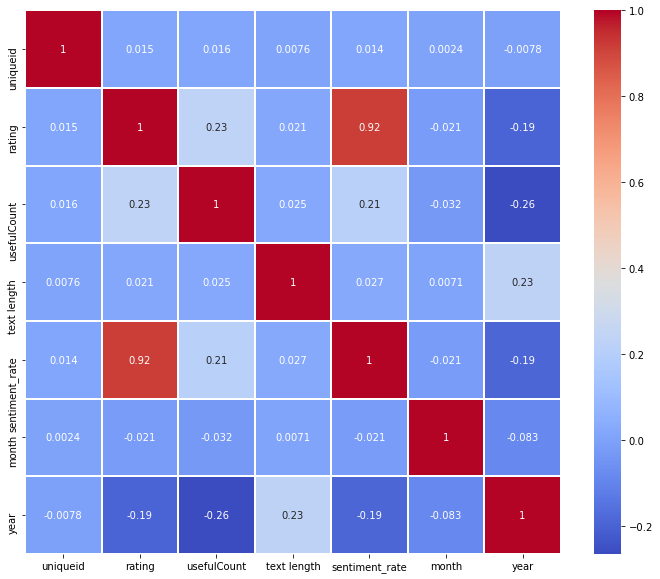

In [34]:
# Lets have an overview of relationship
plt.figure(figsize=(12,10))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', linecolor='white', linewidths=1)

### Comment

There seems to be no strong correlation between variables. The only execption is between rating and sentiment, however sentiment was encoded from ratings. Ratings below 5 were encoded as 0 while 6 and above were encoded as 1.  

### drugName

In [35]:
stopwords = set(STOPWORDS)

In [36]:
# Define a function for wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 16))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [37]:
df_train.drugName.value_counts().iloc[:10].iplot(kind='bar', 
                                           title='Top 10 Most Frequent Drugs',
                                          xTitle='Drug Name',
                                          yTitle='Count',
                                          color='indianred')

### Comment
The most frequent drugs are Levonogestrel (3657), Etonogestrel(3365) and Ethinyl estradiol/norethindrone (2850).

In [38]:
rate_ls = []

for i in df_train.drugName.unique():
    
    if np.sum(df_train.drugName == i ) >= 10:
        rate_ls.append((i, np.sum(df_train[df_train.drugName == i].rating)/ np.sum(df_train.drugName == i)))
        
avg_rate = pd.DataFrame(rate_ls)

In [39]:
# Top 10 Drugs by rating
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Zutripro,10.000000
1,Chlorpheniramine / hydrocodone / pseudoephedrine,10.000000
2,Silver sulfadiazine,9.972222
3,Drixoral Cold and Allergy,9.948718
4,Dexbrompheniramine / pseudoephedrine,9.947368
5,Emend,9.900000
6,Aprepitant,9.900000
7,Tegaserod,9.812500
8,Zelnorm,9.687500
9,Cyanocobalamin,9.666667


### Comment
Drugs that have the best average rating are Zutripro, Chlorpeniramine and Silver sulfadiazine. 

In [40]:
# Bottom 10 Drugs by rating
avg_rate.tail(10)

,0,1
1371,Prevnar 13,3.363636
1372,Fosamax,3.166667
1373,Blisovi 24 Fe,3.088889
1374,Opdivo,3.083333
1375,Miconazole,3.033000
1376,Monistat 7,3.032258
1377,Alendronate,2.954545
1378,Yuvafem,2.318182
1379,Monistat 1-Day or Night Combination Pack,1.416667
1380,ProAir RespiClick,1.193548


### Comment
Drugs that have the lowest rating are ProAir RespiClick, Monistat 1-Day or Night Combination Pack and Yuvafem. 

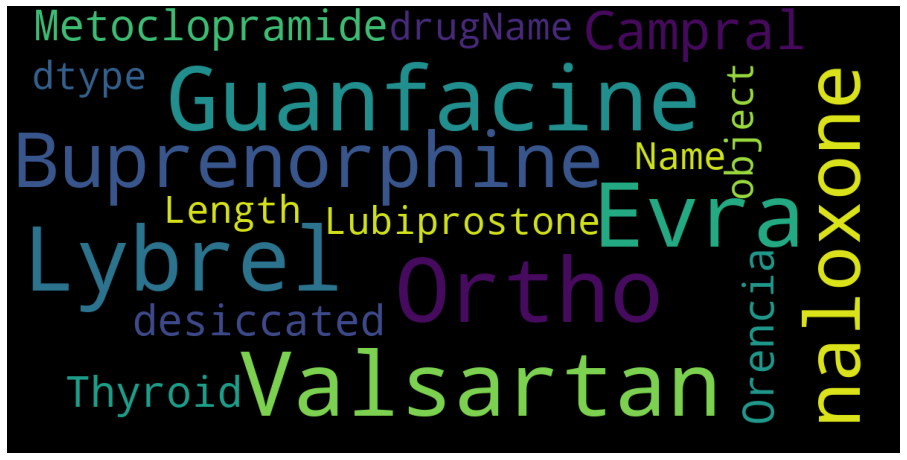

In [41]:
show_wordcloud(df_train['drugName'])

### Comment
The most common words in drugname are Valsartan, Lybrel, Buprenorphine, Guanfacine and Naloxone. 

## Condition

In [42]:
df_train.condition.value_counts().iloc[:10].iplot(kind='bar', 
                                           title='Top 10 Most Frequent Conditions',
                                          xTitle='Condition',
                                          yTitle='Count',
                                           color='midnightblue')

### Comment
The most common conditions are Birth Control (28.788K) and Depression (9069). 

In [43]:
df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False).iloc[:20].iplot(kind='bar',
                                                                                            title='Number of drugs by condition',
                                                                                            xTitle='condition',
                                                                                            yTitle='Count',
                                                                                            color='springgreen')

### Comment
Pain condition has the most number of drugs 200 available, follow by Birth Control 172 drugs availble. 

In [44]:
# These 84 comments will be removed
len(df_train[df_train['condition']=='3</span> users found this comment helpful.'])

84

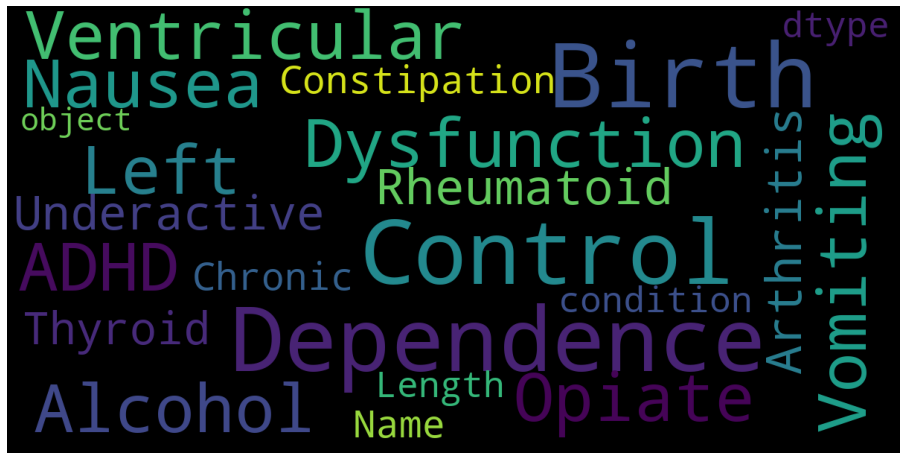

In [45]:
show_wordcloud(df_train['condition'])

### Comment
Within condition, the most commmon words are Control, Ventricular, Birth Dysfunction, Alcohol, ADHD, Constipation and Vomiting. 

## Review

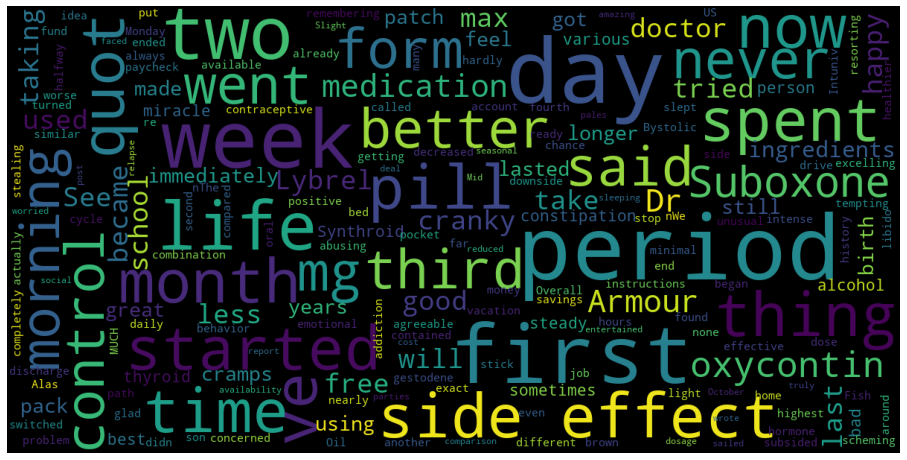

In [46]:
show_wordcloud(df_train['review'])

### Comment
In review, the most common words are side effect, two, day, better, week, month, mg, third, period, first, spent, suboxone, life, started, morning, never, good etc

In [47]:
df_train['usefulCount'].sort_values(ascending=False)

33552     1291
6716      1291
4249      1247
21708     1247
146145    949 
         ...  
156720    0   
134835    0   
50779     0   
156724    0   
51326     0   
Name: usefulCount, Length: 161297, dtype: int64

Text(0.5, 0.98, 'Histogram on Text Length')

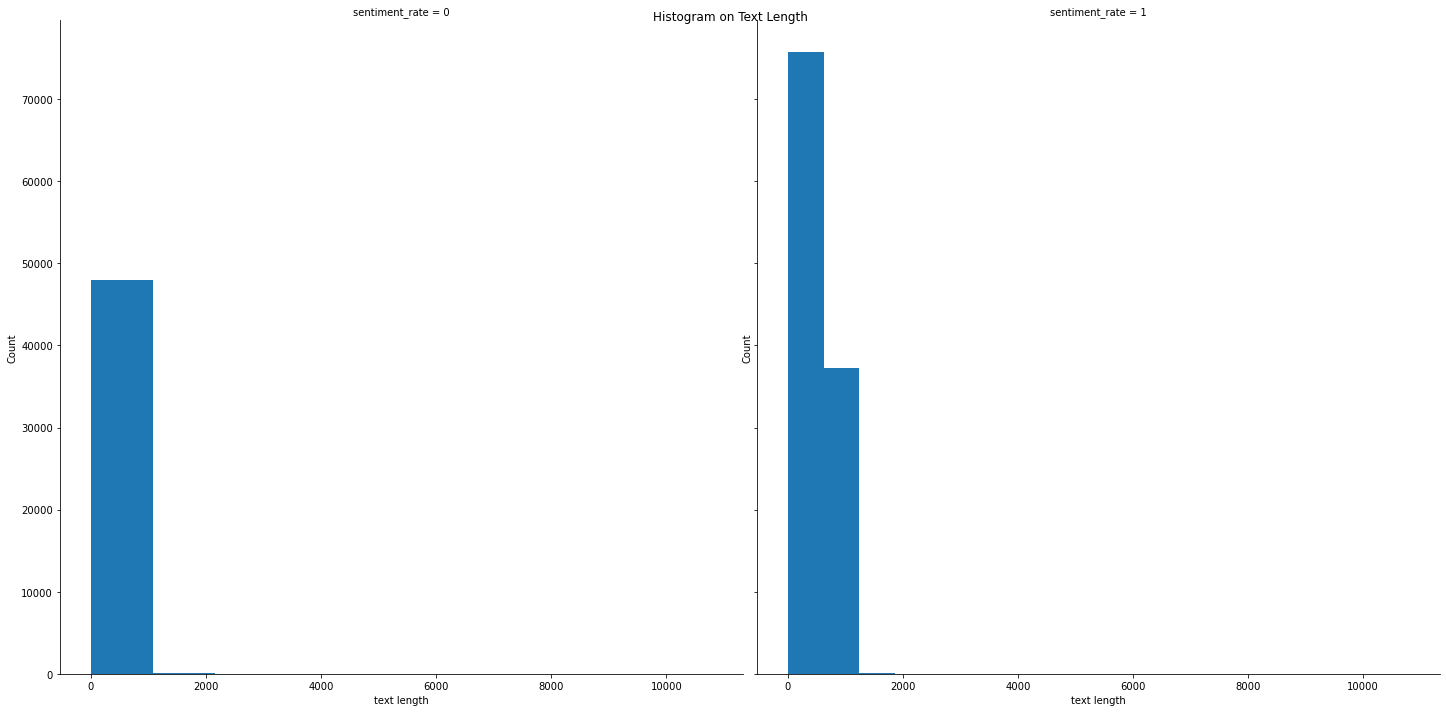

In [48]:
g = sns.FacetGrid(df_train,col='sentiment_rate', height=10, aspect=1)
g.map(plt.hist,'text length')
g.axes[0,0].set_ylabel('Count')
g.axes[0,1].set_ylabel('Count')
g.fig.suptitle('Histogram on Text Length')

### Comment
There are more positive sentiments compared to negative sentiments. Positive and negative sentiment have similar text length. 

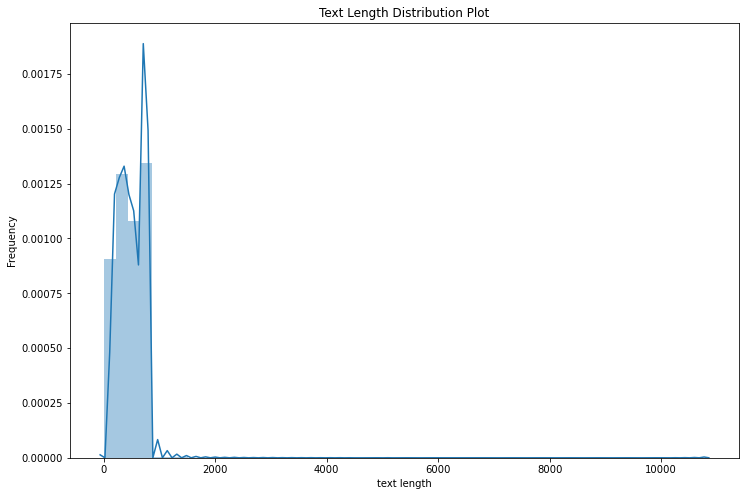

In [49]:
plt.figure(figsize=(12,8))
plt.title('Text Length Distribution Plot')
plt.ylabel('Frequency')
sns.distplot(df_train['text length'])

### Comment
Text length are not normally distributed. Most review were around 1500 text length. There were some much longer text length. 

In [50]:
# Lets take a look at the longest text. 
df_train[df_train['text length']==10787]
# Seems like an unhappy review

uniqueid     drugName condition  \
75663  121004    Venlafaxine  Migraine   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

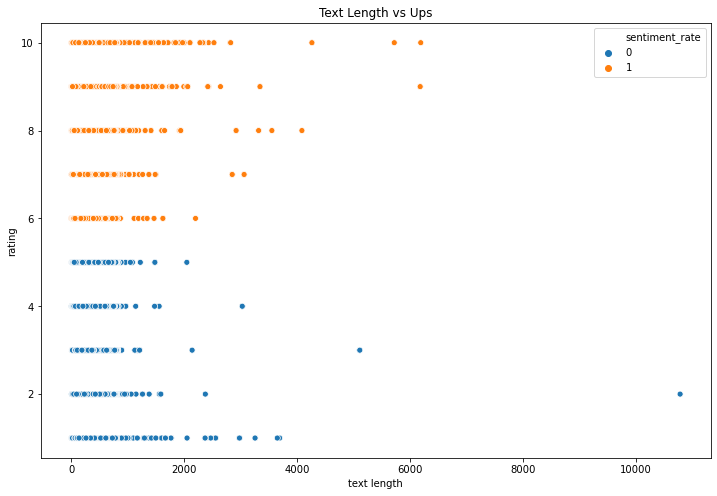

In [51]:
# Lets take alook at text length to rating
plt.figure(figsize=(12,8))
plt.title('Text Length vs Ups')
sns.scatterplot(x='text length',y='rating',data=df_train, hue='sentiment_rate')

### Comment
There seems to be no correlation between rating and text length. 

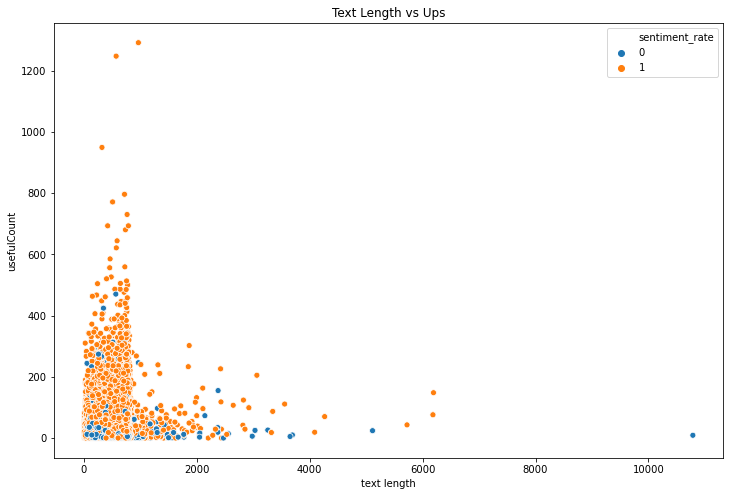

In [52]:
# Lets take alook at text length to ups
# There seems to be three outliers, lets investigate further
plt.figure(figsize=(12,8))
plt.title('Text Length vs Ups')
sns.scatterplot(x='text length',y='usefulCount',data=df_train, hue='sentiment_rate')

### Comment
There is no correlation between usefulCount and text length. Most useful reviews tend be below 2000 text length. 

In [53]:
df_train.rating.value_counts().iplot(kind='bar', 
                               title='Rating Count',
                               xTitle='Rating',
                               yTitle='Count',
                               color='slateblue')

### Comment
Most of the reviews tends to be good, there are 50.989K 10 rating, 27.531K 9 rating and 21.619K 1 rating. Seems like those who wrote a review were either happy or unhappy customers. Moderate customers tends not to write review. 

In [54]:
from collections import defaultdict

In [55]:
df_train_ratings_above_5 = df_train[df_train['rating']>5]
df_train_ratings_below_5 = df_train[df_train['rating']<6]

In [56]:
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(" ") if token !="" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [57]:
def horizontal_bar_chart(df_train, color):
    trace = go.Bar(
    y=df_train['word'].values[::-1],
    x=df_train['wordcount'].values[::-1],
    showlegend=False,
    orientation='h',
    marker=dict(color=color,))
    
    return trace

In [58]:
freq_dict = defaultdict(int)
for sent in df_train_ratings_below_5['review']:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns=['word','wordcount']
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'red')

freq_dict = defaultdict(int)
for sent in df_train_ratings_above_5['review']:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns=['word','wordcount']
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'green')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                         subplot_titles=['Frequent words of rating 1 to 5',
                                        'Frequent words of rating 6 to 10'])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title='Word Count Plots')
py.iplot(fig, filename='word-plots')

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Comment
Positive and negative reviews tends to talk about the same thing. Both talk about side effects, birth control and when they started taking the drug. 

## Date Time

In [59]:
df_train.year.value_counts().iplot(kind='bar', 
                               title='Review Count',
                               xTitle='Year',
                               yTitle='Count',
                               color='slateblue')

### Comment
Number of review increases of the year, it peaks at 2016. 

In [60]:
df_train.month.value_counts().iplot(kind='bar', 
                               title='Rating Count',
                               xTitle='Year',
                               yTitle='Count',
                               color='blue')

### Comment
Review tends to be consistent across months. 

In [61]:
df_train.groupby(['year'])['rating'].mean().iplot(kind='line')

### Comment
Overall trend of rating is dropping over the years. This is a worrisome trend for pharmaceutical companies, in 2008 the average rating was 9 but in 2017 average rating dropped ot 6. Companies need to investigate further what lead to the dropped in rating. 

## Data Preprocessing

In [62]:
### Duplicated reviews removed 
df_train['review'].drop_duplicates(keep='first', inplace=True)
df_test['review'].drop_duplicates(keep='first', inplace=True)

In [63]:
## Making sure all duplicated rows dropped 
df_train['review'].duplicated().value_counts()
df_test['review'].duplicated().value_counts()

False    48280
Name: review, dtype: int64

In [64]:
# Dropping all null cells
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [65]:
# Checking all null cells dropped 
df_train.isnull().sum()

uniqueid          0
drugName          0
condition         0
review            0
rating            0
date              0
usefulCount       0
text length       0
sentiment_rate    0
month             0
year              0
dtype: int64

In [66]:
# Checking all null cells dropped
df_test.isnull().sum()

uniqueid          0
drugName          0
condition         0
review            0
rating            0
date              0
usefulCount       0
text length       0
sentiment_rate    0
month             0
year              0
dtype: int64

In [67]:
# These 84 reviews will be removed
df_train = df_train[df_train['condition']!='3</span> users found this comment helpful.']

In [68]:
# Making sure the reviews were removed
len(df_train[df_train['condition']=='3</span> users found this comment helpful.'])

0

In [69]:
# I have seen some emojis in review, it needs to be removed
def strip_emoji(text):
    RE_EMOJI = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    return RE_EMOJI.sub(r'', text)

In [70]:
def cleaner(text):
    # Make lowercase
    text = text.lower()
    
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)

    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    
    # Remove emoji
    text = strip_emoji(text)
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = ''.join(c for c in text if c <= '\uFFFF') 
    
    return text

In [71]:
# Applying function
df_train['review'] = df_train['review'].apply(cleaner)
df_test['review'] = df_test['review'].apply(cleaner)

In [72]:
# I have chosen to use lemmatizer over porter stemmer because 
# Lemmatization, takes into consideration the morphological analysis of the words.
lemmatizer = WordNetLemmatizer()

In [73]:
def lemmatize_words(text):
    words = text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words

In [74]:
df_train['review'] = df_train['review'].apply(lemmatize_words)
df_test['review'] = df_test['review'].apply(lemmatize_words)

In [75]:
df_train.to_csv("../datasets/df_train_cleaned.csv", index=False)
df_test.to_csv("../datasets/df_test_cleaned.csv", index=False)

In [76]:
# Checking df_train_cleaned export properly
df_train_cleaned = pd.read_csv("../datasets/df_train_cleaned.csv")
df_train_cleaned.head()

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate,month,year
0,206461,Valsartan,Left Ventricular Dysfunction,ha side effect take combination bystolic and fish oil,9.0,2012-05-20,27,79,1,5,2012
1,95260,Guanfacine,ADHD,son halfway through his fourth week intuniv became concerned when began this last week when started taking the highest dose will for two day could hardly get out bed wa very cranky and slept for nearly hour drive home from school vacation very unusual for him called his doctor monday morning and she said stick out few day see how did school and with getting the morning the last two day have been problem free much more agreeable than ever le emotional good thing le cranky remembering all the thing should overall his behavior better have tried many different medication and far this the most effective,8.0,2010-04-27,192,741,1,4,2010
2,92703,Lybrel,Birth Control,used take another oral contraceptive which had pill cycle and wa very happy very light period max day other side effect but contained hormone gestodene which not available switched lybrel because the ingredient are similar when other pill ended started lybrel immediately first day period the instruction said and the period lasted for two week when taking the second pack same two week and now with third pack thing got even worse third period lasted for two week and now the end the third week still have daily brown discharge the positive side that didn have any other side effect the idea being period free wa tempting ala,5.0,2009-12-14,17,755,0,12,2009
3,138000,Ortho Evra,Birth Control,this first time using any form birth control glad went with the patch have been for month first decreased libido but that subsided the only downside that made period longer day exact used only have period for day max also made cramp intense for the first two day period never had cramp before using birth control other than that happy with the patch,8.0,2015-11-03,10,448,1,11,2015
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone ha completely turned life around feel healthier excelling job and always have money pocket and saving account had none those before suboxone and spent year abusing oxycontin paycheck wa already spent the time got and started resorting scheming and stealing fund addiction all that history you ready stop there good chance that suboxone will put you the path great life again have found the side effect minimal compared oxycontin actually sleeping better slight constipation about for truly amazing the cost pale comparison what spent oxycontin,9.0,2016-11-27,37,719,1,11,2016


In [77]:
# Checking df_test_cleaned export properly
df_test_cleaned = pd.read_csv("../datasets/df_test_cleaned.csv")
df_test_cleaned.head()

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate,month,year
0,163740,Mirtazapine,Depression,tried few antidepressant over the year citalopram fluoxetine amitriptyline but none those helped with depression insomnia amp anxiety doctor suggested and changed onto mirtazapine and this medicine ha saved life thankfully have had side effect especially the most common weight gain actually lost alot weight still have suicidal thought but mirtazapine ha saved,10.0,2012-02-28,22,439,1,2,2012
1,206473,Mesalamine,"Crohn's Disease, Maintenance",son ha crohn disease and ha done very well the asacol ha complaint and show side effect ha taken many nine tablet per day one time been very happy with the result reducing his bout diarrhea drastically,8.0,2009-05-17,17,268,1,5,2009
2,159672,Bactrim,Urinary Tract Infection,quick reduction symptom,9.0,2017-09-29,3,29,1,9,2017
3,39293,Contrave,Weight Loss,contrave combine drug that were used for alcohol smoking and opioid cessation people lose weight because also help control over eating have doubt that most obesity caused from sugar carb addiction which just powerful any drug have been taking for five day and the good news seems work immediately feel hungry before want food now really don care eat just fill stomach since have only been few day don know lost weight don have scale but clothes feel little looser maybe pound two hoping that after few month this medication will develop healthier habit that can continue without the aid contrave,9.0,2017-03-05,35,782,1,3,2017
4,97768,Cyclafem 1 / 35,Birth Control,have been this birth control for one cycle after reading some the review this type and similar birth control wa bit apprehensive start giving this birth control out have not been long enough for far love this birth control side effect have been minimal it like not even birth control have experienced mild headache here and there and some nausea but other than that ive been feeling great got period cue the third day the inactive pill and had idea wa coming because had zero pm period wa very light and barely had any cramping had unprotected sex the first month and obviously didn get pregnant very pleased highly recommend,9.0,2015-10-22,4,762,1,10,2015
